<a href="https://colab.research.google.com/github/AkkiNikumbh/ML-EXPERIMENTS/blob/main/AkashSingh_23CS036_Experiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets.iloc[:, 0]

In [2]:
# 2. DATA PREPROCESSING
# Handle missing values (replace '?' with NaN then drop)
X = X.replace('?', np.nan).dropna()
y = y[X.index]  # Align targets

# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Convert to numpy
X = X.to_numpy()
y = np.where(y == '>50K', 1, 0)

# Split: 80% Train / 20% Temp → then split Temp into 50/50 = 10% Val / 10% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [3]:
# 3 DECISION TREE FROM SCRATCH
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=5, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    # Impurity Functions
    def _gini(self, y):
        p = np.bincount(y) / len(y)
        return 1 - np.sum(p ** 2)

    def _entropy(self, y):
        p = np.bincount(y) / len(y)
        p = p[p > 0]
        return -np.sum(p * np.log2(p))

    def _impurity(self, y):
        return self._gini(y) if self.criterion == "gini" else self._entropy(y)

    # Best Split Finder
    def _best_split(self, X, y):
        best_gain, best_feat, best_thresh = 0, None, None
        parent_impurity = self._impurity(y)

        for feat in range(X.shape[1]):
            values = np.unique(X[:, feat])
            for thresh in values:
                left = y[X[:, feat] <= thresh]
                right = y[X[:, feat] > thresh]
                if len(left) == 0 or len(right) == 0:
                    continue
                gain = parent_impurity - (
                    (len(left) / len(y)) * self._impurity(left)
                    + (len(right) / len(y)) * self._impurity(right)
                )
                if gain > best_gain:
                    best_gain, best_feat, best_thresh = gain, feat, thresh

        return best_feat, best_thresh

    # Recursively Build Tree
    def _build(self, X, y, depth=0):
        # Leaf stop conditions
        if (len(np.unique(y)) == 1) or \
           (self.max_depth is not None and depth >= self.max_depth) or \
           (len(y) < self.min_samples_split):
            return np.bincount(y).argmax()  # Return class label

        feat, thresh = self._best_split(X, y)

        # If no valid split found - make leaf
        if feat is None:
            return np.bincount(y).argmax()

        left_idx = X[:, feat] <= thresh
        right_idx = X[:, feat] > thresh

        return {
            "feature": feat,
            "threshold": thresh,
            "left": self._build(X[left_idx], y[left_idx], depth + 1),
            "right": self._build(X[right_idx], y[right_idx], depth + 1)
        }

    # Public Fit
    def fit(self, X, y):
        self.tree = self._build(X, y)

    # Prediction for One Row
    def _predict_one(self, x, node):
        if not isinstance(node, dict):
            return node  # Leaf reached (class label)

        if x[node["feature"]] <= node["threshold"]:
            return self._predict_one(x, node["left"])
        else:
            return self._predict_one(x, node["right"])

    # Predict on Full Dataset
    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])


In [4]:
# 4. TRAIN / VALIDATE
model = DecisionTree(max_depth=4, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.8524988942945599


In [5]:
# 5. EVALUATION ON TEST SET
y_test_pred = model.predict(X_test)
print("\nFinal Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1-Score:", f1_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Final Evaluation Metrics:
Accuracy: 0.8485518461198319
Precision: 0.6596491228070176
Recall: 0.2422680412371134
F1-Score: 0.354382657869934
Confusion Matrix:
 [[3650   97]
 [ 588  188]]


In [6]:
# 6. COMPARE WITH SKLEARN
from sklearn.tree import DecisionTreeClassifier

sk_model = DecisionTreeClassifier(max_depth=4, criterion="entropy")
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)

print("\n Sklearn Accuracy:", accuracy_score(y_test, sk_pred))


 Sklearn Accuracy: 0.8485518461198319


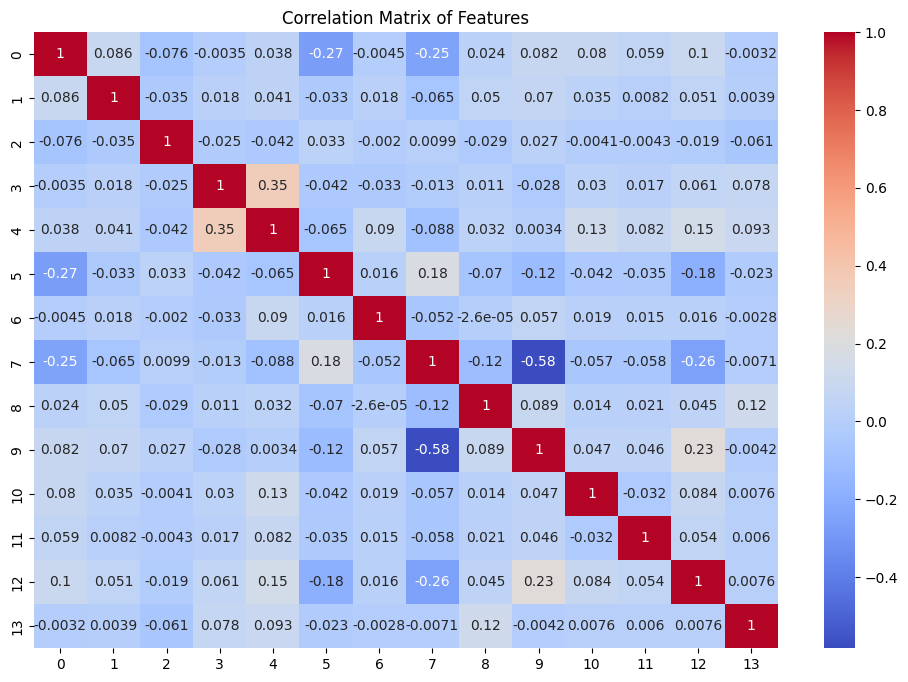

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()